Code source: Tutorial by Giorgio Domenichini

CPHF: CPHF (Coupled Perturbed Hartree-Fock) alchemical derivatives are quantities used in computational chemistry and quantum chemistry to calculate the change in molecular properties with respect to changes in the nuclear positions or atomic charges.

Gaussian-type orbitals (GTOs) are mathematical functions commonly used to represent atomic orbitals in quantum chemistry calculations. They are named after the Gaussian distribution function that describes their radial behavior. GTOs provide a flexible and efficient basis for approximating the wavefunctions of electrons in molecules.

Basis sets are a set of mathematical functions that are used to approximate the wave functions of electrons in molecules

In [2]:
from pyscf import gto,scf
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
import os
import ast

%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# mol_NN = gto.M(atom= "N 0 0 0; N 0 0 2.1",
#                unit="Bohr",
#                basis="unc-cc-pvdz")

In [9]:
# mf = scf.RKS(mol_NN) # create a restricted Kohn-Sham (RKS) mean-field object used for electronic structure calculation
# mf.xc = "PBE0" # sets the exchange-correlation (XC) functional to "PBE0"
# energy = mf.scf()

converged SCF energy = -109.415080022349


In [10]:
# ap_nn=AP(mf,sites=[0,1]) # prepare to perform alchemical perturbing DFT calculations
# H = ap_nn.build_hessian()
# print(H)

[[-3.26630067  0.50149887]
 [ 0.50149887 -3.26630067]]


## Calculating Hessian ##

In [11]:
# create the NN molecule
mol_NN_pcX2=gto.M(atom= "N 0 0 0; N 0 0 2.1",
                  unit="Bohr",
                  basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[6,7,8]))

# the unit corresponds the length unit used when specifying atomic positions
# the pcX-2 basis set is a specialized basis set for systems containing C, N, and O

In [12]:
def get_energy_DFT(mol):
    """ 
    Compute the total energy of a given molecule, in a.u., using DFT calculation

    Args:
        mol (pyscf.gto.mole.Mole): a PySCF Gaussian-type orbital (GTO) molecule object 
    
    Returns:
        mf (pyscf.dft.rks.RKS): the mean-field object for the molecule (used for other DFT related calculations) 
        energy (float): the total energy of the molecule
    """

    mf = scf.RKS(mol) # create a restricted Kohn-Sham (RKS) mean-field object used for electronic structure calculation
    mf.xc = "PBE0" # sets the exchange-correlation (XC) functional to "PBE0"
    energy = mf.scf() # performs self-consistent field (SCF) calculations

    return energy, mf

In [13]:
def get_energy_HF(mol):
    """ 
    Compute the total energy of a given molecule, in a.u., using DFT calculation

    Args:
        mol (pyscf.gto.mole.Mole): a PySCF Gaussian-type orbital (GTO) molecule object 
    
    Returns:
        mf (pyscf.dft.rks.RKS): the mean-field object for the molecule (used for other DFT related calculations) 
        energy (float): the total energy of the molecule
    """

    mf = scf.RHF(mol) # create a restricted Hartree-Fock (RHF) mean-field object used for electronic structure calculation
    energy = mf.scf() # performs self-consistent field (SCF) calculations

    return energy, mf

In [14]:
# Calculate the energy and the Hessian

energy_nn, mf_nn = get_energy_DFT(mol_NN_pcX2)
ap_nn=AP(mf_nn,sites=[0,1]) # prepare to perform alchemical perturbing DFT calculations
H = ap_nn.build_hessian()
print(H)

converged SCF energy = -109.444276410408
[[-3.30695508  0.47774726]
 [ 0.47774726 -3.30695508]]


In [16]:
# compute the diagnalization matrix (of eigenvectors) Q

epsilon, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)
print(Q_inv)

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


## Import Training Data ##

In [17]:
def get_diatomic_data(ap_mol):
    """ 
    Get the diatomic molecule data and store them in pandas dataframe
    If there exist a file with pre-calculated diatomic energy, directly open it.
    If not, calculate the energy for each molecule and store the data as a separate file

    Args:
        ap_mol (APDFT_perturbator): the reference molecule (used for APDFT calculations)
    
    Returns:
        diatomic_data (pandas dataframe): dataframe containing the perturbation vector and the energy of each molecule
    """
    
    if os.path.isfile('diatomic_data_w_energy.csv'):
        diatomic_data = pd.read_csv('diatomic_data_w_energy.csv', header = 0)
        diatomic_data['dx'] = diatomic_data['dx'].apply(lambda x: ast.literal_eval(x))
    
    elif os.path.isfile('diatomic_data.csv'):
        diatomic_data = pd.read_csv('diatomic_data.csv', header = 0)
        
        # creating the dx column and calculate the total energy of each molecule
        diatomic_data['dx'] = None
        diatomic_data['energy'] = None

        for index, row in diatomic_data.iterrows():
            dx = [row['charge_1'] - 7, row['charge_2'] - 7] # calculates the dx vector from the charge of each atom
            
            # target_mol = FcM_like(mol, fcs=dx) # build target molecule from specified perturbation
            target_energy = ap_mol.target_energy(dx)

            diatomic_data.at[index, 'dx'] = dx
            diatomic_data.at[index, 'energy'] = target_energy
            diatomic_data.to_csv('diatomic_data_w_energy.csv')
    
    return diatomic_data

In [19]:
diatomic_data = get_diatomic_data(ap_nn)
print(diatomic_data)
# print(diatomic_data['dx'].dtype)

    Unnamed: 0   Name  charge_1  charge_2        dx      energy
0            0     N2         7         7    [0, 0] -108.982443
1            1   NO +         7         8    [0, 1] -128.950506
2            2   CN -         6         7   [-1, 0]  -92.335593
3            3   NC -         7         6   [0, -1]  -92.335593
4            4   ON +         8         7    [1, 0] -128.950506
5            5  O2 2+         8         8    [1, 1] -148.301451
6            6  NF 2+         7         9    [0, 2] -152.508900
7            7     CO         6         8   [-1, 1] -112.786392
8            8  BN 2-         5         7   [-2, 0]  -78.809317
9            9  C2 2-         6         6  [-1, -1]  -75.324778
10          10  NB 2-         7         5   [0, -2]  -78.809316
11          11     OC         8         6   [1, -1] -112.786392
12          12  FN 2+         9         7    [2, 0] -152.508900
13          13  OF 3+         8         9    [1, 2] -171.142720
14          14   CF +         6         

In [ ]:
# creating the dx column and calculate the total energy of each molecule

# diatomic_data['dx'] = None
# diatomic_data['energy'] = None

# for index, row in diatomic_data.iterrows():
#     dx = [row['charge_1'] - 7, row['charge_2'] - 7] # calculates the dx vector from the charge of each atom
#     energy = ap_nn.target_energy(dx) # calculates the energy of the molecule
#     diatomic_data.at[index, 'dx'] = dx
#     diatomic_data.at[index, 'energy'] = energy
# print(diatomic_data)

In [ ]:
# diatomic_data.to_csv('diatomic_data_w_energy.csv', index=False)

In [20]:
# express each molecule using the ANM basis
# i.e. c = Q_inv @ dx

dx_array = np.array(diatomic_data['dx'].tolist())
# print(dx_array)

c_array = (Q_inv @ dx_array.T).T
# print(c_array)

# print(c_array.tolist())

diatomic_data['c'] = c_array.tolist()
diatomic_data['coord_0'] = diatomic_data['c'].apply(lambda x: x[0])
diatomic_data['coord_1'] = diatomic_data['c'].apply(lambda x: x[1])

print(diatomic_data)

    Unnamed: 0   Name  charge_1  charge_2        dx      energy   
0            0     N2         7         7    [0, 0] -108.982443  \
1            1   NO +         7         8    [0, 1] -128.950506   
2            2   CN -         6         7   [-1, 0]  -92.335593   
3            3   NC -         7         6   [0, -1]  -92.335593   
4            4   ON +         8         7    [1, 0] -128.950506   
5            5  O2 2+         8         8    [1, 1] -148.301451   
6            6  NF 2+         7         9    [0, 2] -152.508900   
7            7     CO         6         8   [-1, 1] -112.786392   
8            8  BN 2-         5         7   [-2, 0]  -78.809317   
9            9  C2 2-         6         6  [-1, -1]  -75.324778   
10          10  NB 2-         7         5   [0, -2]  -78.809316   
11          11     OC         8         6   [1, -1] -112.786392   
12          12  FN 2+         9         7    [2, 0] -152.508900   
13          13  OF 3+         8         9    [1, 2] -171.14272

## Kernel Ridge Regression ##

In [21]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
X = diatomic_data[['coord_0', 'coord_1']]
y = diatomic_data['energy']

In [22]:
# Gaussian kernel

gaussian_KRR = KernelRidge(kernel='rbf', gamma=0.05, alpha = 0.05)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(gaussian_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Fold 1: MSE = 35.43271127260019
Fold 2: MSE = 16.070377138394026
Fold 3: MSE = 37.07656197835707
Fold 4: MSE = 81.23406968636036
Fold 5: MSE = 85.44062013399831
Average MSE across all folds: 51.05086804194199


In [23]:
# Polynomial Kernel

poly_KRR = KernelRidge(kernel='polynomial', degree=3, alpha = 0.01)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(poly_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Fold 1: MSE = 0.14559210190953176
Fold 2: MSE = 0.06559608057629548
Fold 3: MSE = 0.038410377354150385
Fold 4: MSE = 0.037797165459715495
Fold 5: MSE = 0.07577509843613081
Average MSE across all folds: 0.0726341647471648


At first glance, polynomial kernels appear more promising. 

## Hyperparameter Tuning ##

In [ ]:
# Hyperparam tuning
# Grid search round 1

# param_grid = {
#     'alpha': [0.005, 0.01, 0.05, 0.1, 0.5],
#     'kernel': ['poly'],  
#     'degree': [1, 2, 3, 4], 
#     'coef0': [0.0, 0.5, 1.0, 2.0], 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# Hyperparam tuning
# Grid search round 2

# param_grid = {
#     'alpha': np.linspace(0.004, 0.006, 10),
#     'kernel': ['poly'],  
#     'degree': [3], 
#     'coef0': np.linspace(1.8, 2.2, 10), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# Hyperparam tuning
# Grid search round 3

# param_grid = {
#     'alpha': np.linspace(0.002, 0.004, 10, endpoint=True),
#     'kernel': ['poly'],  
#     'degree': [3], 
#     'coef0': np.linspace(2.2, 2.4, 10, endpoint=True), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# Hyperparam tuning
# Grid search round 4

# param_grid = {
#     'alpha': np.linspace(0.001, 0.002, 10, endpoint=True),
#     'kernel': ['poly'],  
#     'degree': [3], 
#     'coef0': np.linspace(2.4, 2.6, 10, endpoint=True), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# Hyperparam tuning
# Grid search round 5

# param_grid = {
#     'alpha': np.linspace(0.0001, 0.001, num=10, endpoint=True),
#     'kernel': ['poly'],  
#     'degree': [3], 
#     'coef0': np.linspace(2.6, 5, num=10, endpoint=True), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# Hyperparam tuning
# Grid search round 6

# param_grid = {
#     'alpha': np.linspace(0.00001, 0.0001, num=10, endpoint=True),
#     'kernel': ['poly'],  
#     'degree': [3], 
#     'coef0': np.linspace(5, 20, num=10, endpoint=True), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

## Learning Curve ##

In [24]:
def evaluate_performance(model, X, y, num_training_sample, num_trials):

    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_pred)) # Root mean squared error
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)
    return average_error, std_dev_error

In [25]:
best_params = {'alpha': 0.0001, 'coef0': 20.0, 'degree': 3, 'kernel': 'poly'}
poly_KRR = KernelRidge(**best_params)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 21)]
num_trials = 20

for num_training_sample in training_size:
    index = num_training_sample - 1
    average_error, std_dev_error = evaluate_performance(poly_KRR, X, y, num_training_sample, num_trials)
    model_performance.at[index, 'training size'] = num_training_sample
    model_performance.at[index, 'average RMSE'] = average_error
    model_performance.at[index, 'standard deviation'] = std_dev_error
    print(f"Training size: {num_training_sample}. Average RMSE: {average_error}")

Training size: 1. Average RMSE: 53.95298972522943
Training size: 2. Average RMSE: 37.699425463588575
Training size: 3. Average RMSE: 10.894674506768222
Training size: 4. Average RMSE: 5.927539426657742
Training size: 5. Average RMSE: 3.2741701880733274
Training size: 6. Average RMSE: 0.6220215906517907
Training size: 7. Average RMSE: 0.6220215906517907
Training size: 8. Average RMSE: 0.33134374426799723
Training size: 9. Average RMSE: 0.1972089139593638
Training size: 10. Average RMSE: 0.12203524441055583
Training size: 11. Average RMSE: 0.07685340324050646
Training size: 12. Average RMSE: 0.049536118016594306
Training size: 13. Average RMSE: 0.05073943503761004
Training size: 14. Average RMSE: 0.05073943503761004
Training size: 15. Average RMSE: 0.028913205425347088
Training size: 16. Average RMSE: 0.028913205425347088
Training size: 17. Average RMSE: 0.021053772211740644
Training size: 18. Average RMSE: 0.021053772211740644
Training size: 19. Average RMSE: 0.019464197650977004
Traini

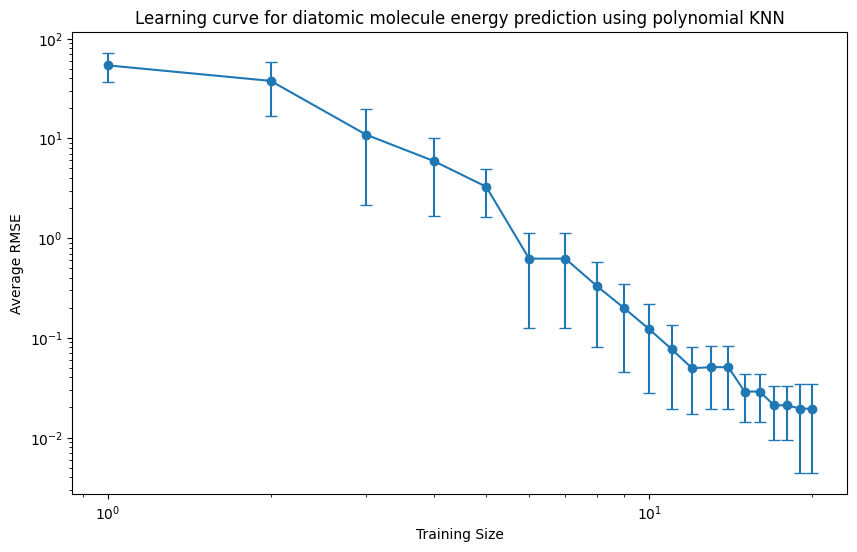

In [26]:
# graphing

graph_x = model_performance['training size']
graph_y = model_performance['average RMSE']
graph_error = model_performance['standard deviation']

# Set figure size
plt.figure(figsize=(10, 6))

# Create line plot with error bars
plt.errorbar(graph_x, graph_y, yerr=graph_error, marker='o', linestyle='-', capsize=4)

# Set axis labels and title
plt.xlabel('Training Size')
plt.ylabel('Average RMSE')
plt.title('Learning curve for diatomic molecule energy prediction using polynomial KNN')

plt.xscale('log')
plt.yscale('log')


# Save the figure as a PNG image
plt.savefig('learning_curve_20_points.png', dpi=300)
plt.show()

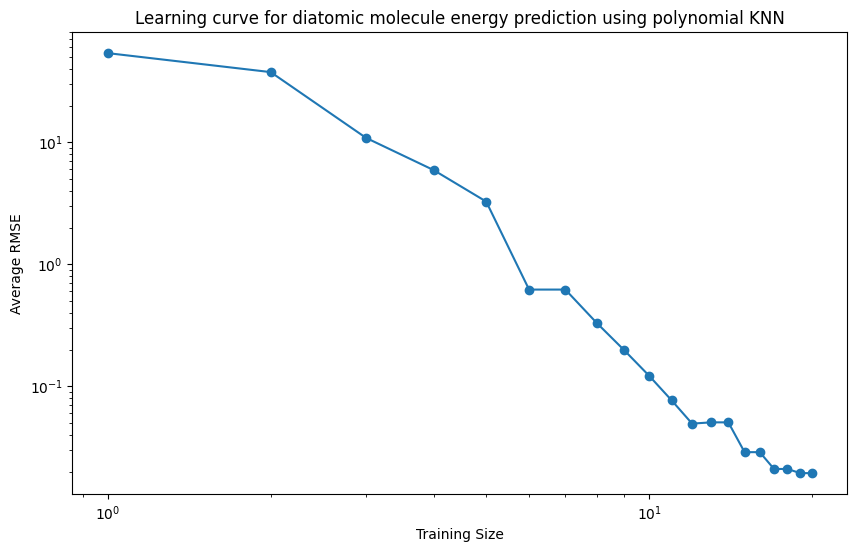

In [27]:
# a version without error bar

plt.figure(figsize=(10, 6))

plt.plot(graph_x, graph_y, marker='o', linestyle='-')

plt.xlabel('Training Size')
plt.ylabel('Average RMSE')
plt.title('Learning curve for diatomic molecule energy prediction using polynomial KNN')

plt.xscale('log')
plt.yscale('log')


# Save the figure as a PNG image
plt.savefig('learning_curve_20_points_no_err_bar.png', dpi=300)
plt.show()

In [ ]:
# learning_data = pd.Series(error, index=training_size)

# ax = learning_data.plot(kind='line')
# ax.set_yscale('log')
# # ax.set_xscale('log')

# plt.xlabel('NUmber of training samples')
# plt.ylabel('MSE [Ha]')
# plt.title('Learning curve for diatomic molecule energy prediction using polynomial KNN')

# plt.savefig('learning_curve_2.png')


In [ ]:
# best_params = {'alpha': 0.0001, 'coef0': 20.0, 'degree': 3, 'kernel': 'poly'}
# poly_KRR = KernelRidge(**best_params)

# total_num_train = X.shape[0]
# error = []
# training_size = []
# num_folds = [2, 3, 5, 21]

# for n in num_folds:
#     k_fold = KFold(n_splits=n, shuffle=True, random_state=42)
#     mse_scores = cross_val_score(poly_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
#     mse_scores = -mse_scores
#     avg_mse = mse_scores.mean()
    
#     error.append(avg_mse)
#     cur_training_size = int(np.round(total_num_train * (1 - 1/n)))
#     training_size.append(cur_training_size)

#     print(f"Training size: {cur_training_size}. MSE = {avg_mse}")